In [1]:
%matplotlib widget
import torch
import os
import copy
if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.timestep import computeTimestep
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
# from sphMath.reference.linear import buildLinearWaveSimulation, runLinearWaveTest
from sphMath.enums import *
from sphMath.reference.sod import plotSod

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
dtype = torch.float64

nx = 800
dim = 1
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4, 1)
CFL = 0.3
goalRadius = 0.8

gamma = 5/3
rho0 = 1
E0 = 1

scheme = SimulationScheme.Monaghan1997
integrationScheme = IntegrationSchemeType.rungeKutta2
viscositySwitch = ViscositySwitch.CullenHopkins
supportScheme = AdaptiveSupportScheme.OwenScheme

domain = buildDomainDescription(l = 2, dim = 1, periodic = True, device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)

In [3]:
from sedov import buildSedov, radius, velocity, beta
import sphMath.reference.sedov as sedov
from scipy.optimize import minimize

particleSystem = buildSedov(nx, dim, domainExtent = 2, periodicDomain=True, rho0=rho0, E0 = E0, initialization = 'singular', gamma = gamma, kernel = kernel, targetNeighbors = targetNeighbors, dtype = dtype, device = device, shellSampling= False, SimulationSystem = SimulationSystem) 

dt = computeTimestep(scheme, 1e-3, particleSystem.systemState, solverConfig, None)

answer = sedov.SedovSolution(
    nDim = 1,
    gamma = solverConfig['fluid']['gamma'],
    rho0 = rho0,
    E0 = E0,
    h0 = 2/nx
)
nu1 = 1.0/(answer.nu + 2.0)
nu2 = 2.0*nu1
goalTime = (goalRadius*(answer.alpha*rho0/E0)**nu1)**(1.0/nu2)
vs, r2, v2, rho2, P2 = answer.shockState(goalTime)
rad_t = lambda t: radius(beta(dim), E0, t, rho0, 1)
targetTime = minimize(lambda t: (rad_t(t) - goalRadius) ** 2, 0.2).x[0]

print(f'Target Time [paper]: {targetTime:8.4g}, {rad_t(targetTime):8.4g} / {answer.shockState(targetTime)[1]:8.4g}')
print(f'Target Time  [code]: {goalTime:8.4g}, {rad_t(goalTime):8.4g} / {answer.shockState(goalTime)[1]:8.4g}')


True: dxs: [tensor(0.0025, dtype=torch.float64)], ns: [tensor(801, dtype=torch.int32)], nx: 801
Key adaptiveHThreshold not found in config["support"]. Setting adaptiveHThreshold to 0.001
Target Time [paper]:   0.6119,      0.8 /   0.8531
Target Time  [code]:   0.5556,   0.7502 /      0.8


In [4]:
simulationState = copy.deepcopy(particleSystem)

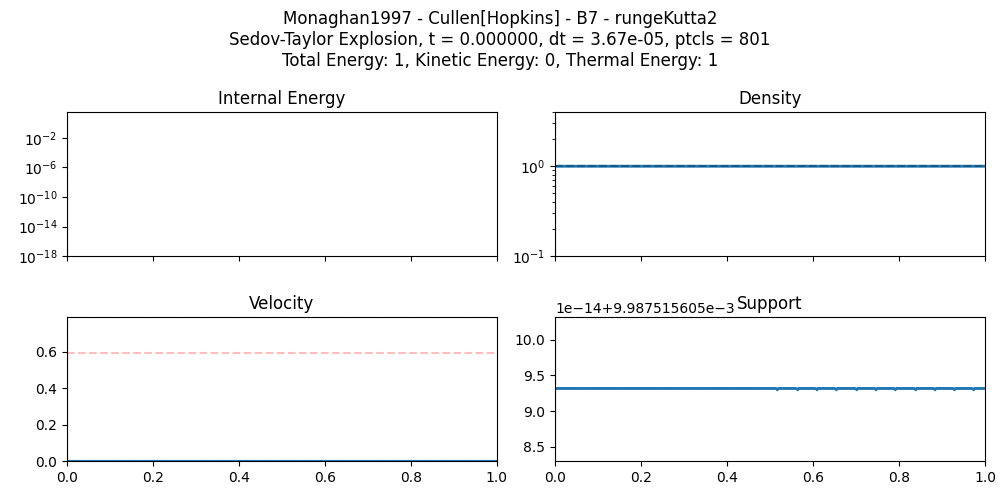

In [5]:
fig, axis = plt.subplots(2, 2, figsize=(10, 5), squeeze=False, sharex=True, sharey=False)

axis[0,0].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.internalEnergies.cpu().numpy(), s = simulationState.systemState.supports.cpu().numpy() * 100)
axis[0,1].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.densities.cpu().numpy(), s = simulationState.systemState.supports.cpu().numpy() * 100)
axis[1,0].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.velocities.cpu().numpy(), s = simulationState.systemState.supports.cpu().numpy() * 100)
axis[1,1].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.supports.cpu().numpy(), s = simulationState.systemState.supports.cpu().numpy() * 100)

axis[0,0].set_title('Internal Energy')
axis[0,1].set_title('Density')
axis[1,0].set_title('Velocity')
axis[1,1].set_title('Support')

kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
totalEnergy = kineticEnergy + thermalEnergy

fig.suptitle(f'{solverConfig["schemeName"]}\nSedov-Taylor Explosion, t = {simulationState.t:2f}, dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')
fig.tight_layout()

# prefix = './images/sedov_1d_201_sharp/'
# os.makedirs(prefix, exist_ok = True)

rt = rad_t(simulationState.t)
# vt = vel_t(simulationState.t)
    
    
def setupPlot(axis, t):
    vs, r2, v2, rho2, P2 = answer.shockState(t)
    rt = rad_t(t)
    
    for ax in axis.flatten():
        ax.axvline(r2, color = 'black', linestyle = '--', alpha = 0.25)
        ax.axvline(-r2, color = 'black', linestyle = '--', alpha = 0.25)
        ax.axvline(rt, color = 'red', linestyle = '--', alpha = 0.25)
        ax.axvline(-rt, color = 'red', linestyle = '--', alpha = 0.25)
        
        
    # axis[1,0].axhline(vt, color = 'black', linestyle = '--', alpha = 0.25)
    axis[1,0].axhline(vs, color = 'black', linestyle = '--', alpha = 0.25)
    axis[1,0].axhline(-vs, color = 'black', linestyle = '--', alpha = 0.25)
    axis[1,0].axhline(v2, color = 'red', linestyle = '--', alpha = 0.25)
    axis[1,0].axhline(-v2, color = 'red', linestyle = '--', alpha = 0.25)
    axis[0,1].axhline(rho0, color = 'black', linestyle = '--', alpha = 0.25)
    axis[0,1].axhline(rho2, color = 'black', linestyle = '--', alpha = 0.25)

    axis[0,0].set_xlim(0, 1)
    axis[0,1].set_xlim(0, 1)
    axis[1,0].set_xlim(0, 1)
    axis[1,1].set_xlim(0, 1)

    axis[0,0].set_ylim(1e-18, 30)
    axis[0,1].set_ylim(0.1, 4)
    axis[1,0].set_ylim(0, vs)

    axis[0,0].set_yscale('log')
    axis[0,1].set_yscale('log')
setupPlot(axis, simulationState.t.cpu() if isinstance(simulationState.t, torch.Tensor) else simulationState.t)

# fig.savefig(f'{prefix}/frame_{0:06d}.png')

In [6]:

import math
fps = 50
exportInterval = 1 / fps
exportSteps = int(math.ceil(exportInterval / dt))
newDt = exportInterval / exportSteps
plotInterval = int(math.floor(exportInterval / newDt))
plotInterval = min(max(plotInterval,1), 40)
print(f'Current dt: {dt}')
print(f'Plot Interval: {plotInterval}')
print(f'export Steps: {exportSteps}')
print(f'New dt: {newDt}')

imagePrefix = './images/sedov_1D/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)

Current dt: 3.674306937015617e-05
Plot Interval: 40
export Steps: 545
New dt: 3.669724770642202e-05


In [7]:
states = []
timesteps = int(goalTime / dt)
# plotInterval = 100

for i in (tq:=tqdm(range(timesteps))):
# while(True):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = simulationState.priorStep)
    simulationState.priorStep = [updates[-1], currentState[-1]]
    
    states.append(copy.deepcopy(simulationState))

    kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
    thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
    totalEnergy = kineticEnergy + thermalEnergy

    tq.set_postfix({
        'Kinetic Energy': kineticEnergy.item(),
        'Thermal Energy': thermalEnergy.item(),
        'Total Energy': totalEnergy.item(),
        'Time': simulationState.t.item(),
    })

    if (i % plotInterval == 0 and i > 0) or i == timesteps - 1:
        axis[0,0].cla()
        axis[0,1].cla()
        axis[1,0].cla()
        axis[1,1].cla()
        
        axis[0,0].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.internalEnergies.cpu().numpy(), s = simulationState.systemState.supports.cpu().numpy() * 100)
        axis[0,1].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.densities.cpu().numpy(), s = simulationState.systemState.supports.cpu().numpy() * 100)
        axis[1,0].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.velocities.cpu().numpy(), s = simulationState.systemState.supports.cpu().numpy() * 100)
        axis[1,1].scatter(simulationState.systemState.positions.cpu().numpy(), simulationState.systemState.supports.cpu().numpy(), s = simulationState.systemState.supports.cpu().numpy() * 100)
        
        axis[0,0].set_title('Internal Energy')
        axis[0,1].set_title('Density')
        axis[1,0].set_title('Velocity')
        axis[1,1].set_title('Support')
                
        setupPlot(axis, simulationState.t.cpu().item())
        fig.suptitle(f'{solverConfig["schemeName"]}\nSedov-Taylor Explosion, t = {simulationState.t:2f}, dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')
        # fig.tight_layout()
        # fig.savefig(f'{prefix}/frame_{i:06d}.png')
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)
        

  0%|          | 0/15121 [00:00<?, ?it/s]

Key alpha_min not found in config["diffusionSwitch"]. Setting alpha_min to 0.02
Key correctGradient not found in config["diffusionSwitch"]. Setting correctGradient to False
Key beta_xi not found in config["diffusionSwitch"]. Setting beta_xi to 2
Conductivity:  torch.Size([801])
Dissipation:  torch.Size([801])
Key alpha_max not found in config["diffusionSwitch"]. Setting alpha_max to 2
Key beta_c not found in config["diffusionSwitch"]. Setting beta_c to 0.7
Key beta_d not found in config["diffusionSwitch"]. Setting beta_d to 0.05
Conductivity:  torch.Size([801])
Dissipation:  torch.Size([801])
Conductivity:  torch.Size([801])
Dissipation:  torch.Size([801])
Conductivity:  torch.Size([801])
Dissipation:  torch.Size([801])
Conductivity:  torch.Size([801])
Dissipation:  torch.Size([801])
Conductivity:  torch.Size([801])
Dissipation:  torch.Size([801])
Conductivity:  torch.Size([801])
Dissipation:  torch.Size([801])
Conductivity:  torch.Size([801])
Dissipation:  torch.Size([801])
Conductivi

KeyboardInterrupt: 

In [ ]:
from sphMath.util import postProcess

postProcess(
    imagePrefix = imagePrefix,
    fps = 50,
    exportName = 'sedov_1D',
    targetLongEdge = 600
)
# def postProcess(imagePrefix, fps, exportName, targetLongEdge = 600):

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Copying video to videos folder
Done!
